In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

from scipy.signal import argrelextrema
import math
import numpy as np
import matplotlib
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.legend_handler import HandlerBase
import matplotlib.pyplot as plt
import sys
import os,glob
import yaml
from scipy.special import gamma
from scipy.optimize import fsolve
from scipy.interpolate import interp1d  
import pandas as pd
import matplotlib.ticker as ticker
from scipy.optimize import curve_fit
from tqdm import tqdm 

%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = 'retina'
plt.rcParams['font.size']=13
plt.rcParams['text.usetex']=True
plt.rcParams['font.family']='stix'
plt.rcParams['figure.figsize']= (6.5,4)
plt.rcParams['figure.dpi']=150
plt.rcParams['axes.facecolor'] = 'white'

---

In [9]:
class VDS0():  

############################# INITIALIZATION #############################
    
    def __init__(self, h = 0.6932, Omega_m = 0.23995, Omega_b = 0.04626, Omega_rad = 9.23640e-5, p_crit = 4.755e-6,
                 rho_crit = 4.755e-6, T0 = 2.7255, kb = 8.617333262145e-5, m_p = 0.93827231, nu = 1.12,
                 Y_p = 0.75, n_e = 0.18820, x_e = 1.16371, sigmaT = 6.65246e-29, c = 3e5, Mpc2cm = 3.086e24, 
                 masses = np.array([1.5e-5,1e-4,1e-3,1e-2,1e-1,1.,10.,100.]), 
                 sigma_array = np.logspace(-10,-40,600)):
        
        self.h = h
        self.H0 = 100*h
        self.Omega_m = Omega_m
        self.Omega_b = Omega_b
        self.Omega_rad = Omega_rad
        self.Y_p = Y_p
        self.m_p = m_p
        self.nu = nu
        self.n_e = n_e
        self.x_e = x_e
        self.sigmaT = sigmaT
        self.rho_crit = 1.256*10**11*Omega_m
        self.rho_b = Omega_b*p_crit
#         self.T_0 = kb*T0*1e-9
        self.T_0 = 2.353e-13        
        self.Mpc2m = Mpc2cm*1e-2
        self.Rx_conerverionFactor = c*Mpc2cm
        
        self.masses = masses
        self.sigma_array = sigma_array
            
############################# SEMI-ANALYTIC FUNCTIONS #############################
    
    def N_0(self,n):
        return pow(2,(5.+n)/2.)*gamma(3.+n/2.)/(3.*np.sqrt(np.pi))

    def mhm2khm(self,Mhm):
        return np.pi/self.h*(((4.*np.pi*self.rho_crit)/(3*Mhm))**(1./3.))
        
    def Rx(self,z,sigma_0, m_x, n):
        return pow(z,2)*self.N_0(n)*self.Y_p*self.rho_b*self.Rx_conerverionFactor*(sigma_0/(m_x+self.m_p))*(pow(((self.T_0*(1+z))/(m_x))+((self.T_0*(1+z))/self.m_p),((1.+n)/2.)))

    def Rx_noZ(self,sigma_0, m_x, n):
        return self.N_0(n)*self.Y_p*self.rho_b*self.Rx_conerverionFactor*(sigma_0/(m_x+self.m_p))*(pow((self.T_0/m_x)+(self.T_0/self.m_p),((1.+n)/2.)))
    
    def Rx_kin(self,z,sigma_0,m_x,n):
        return (pow(z,2) * ((self.T_0*z**2)/(self.z_th(sigma_0,m_x,n)*m_x) + (self.T_0*z)/self.m_p)**((n+1.)/2.))*(self.N_0(n)*self.Y_p*self.rho_b*self.Rx_conerverionFactor*(sigma_0/(m_x+self.m_p)))

    def Rx_th(self,z,sigma_0, m_x, n):
        return pow(z,2)*self.N_0(n)*self.Y_p*self.rho_b*self.Rx_conerverionFactor*(sigma_0/(m_x+self.m_p))*(pow((self.T_0*z)/(m_x)+((self.T_0*z)/self.m_p),((1.+n)/2.)))
    
    def Rgamma(self,z):
        return pow(z,2)*self.n_e*self.x_e*self.sigmaT*self.Mpc2m
    
    def aH(self,z,sigma_0,m_x,n):
        return z*(self.H0*np.sqrt(self.Omega_rad))

    def z_th(self,sigma_0,m_x,n):
        return ((self.H0*np.sqrt(self.Omega_rad)*(m_x+self.m_p))/(self.Rx_noZ(sigma_0,m_x,n)*m_x))**(2./(n+3.))

    def z_kin(self,sigma_0,m_x,n):
        return fsolve(lambda z: z * ((self.T_0*z**2)/((1+self.z_th(sigma_0,m_x,n))*m_x) + (self.T_0*z)/self.m_p)**((n+1.)/2.) - (self.H0*np.sqrt(self.Omega_rad)/(self.N_0(n)*self.Y_p*self.rho_b*self.Rx_conerverionFactor))*(m_x+self.m_p)/sigma_0,self.z_th(sigma_0,m_x,n)/2.)    
    
    def z_gamma(self,sigma_0,m_x,n):
        return fsolve(lambda z: ((self.T_0*z**2)/(self.z_th(sigma_0,m_x,n)*m_x) + (self.T_0*self.z_th(sigma_0,m_x,n))/self.m_p)**((n+1.)/2.) - (self.n_e*self.x_e*self.sigmaT*self.Mpc2m/(self.N_0(n)*self.Y_p*self.rho_b*self.Rx_conerverionFactor))*(m_x+self.m_p)/sigma_0,self.z_th(sigma_0,m_x,n)/2.)    

    def sigma2k(self,sigma_0,m_x,n):
        return 2*(self.H0*np.sqrt(self.Omega_rad)*self.z_kin(sigma_0,m_x,n))*3.33e-6
    
    def sigma2k2(self,sigma_0,m_x,n):
        return 2*(self.H0*np.sqrt(self.Omega_rad)*self.z_gamma(sigma_0,m_x,n))*3.33e-6

    def sig(self,klimit,n,masses):
        sigma = []
        for i in range(len(masses)):
            sigma.append(self.sigma_array[np.argmin(np.abs(self.sigma2k(self.sigma_array,masses[i],n)-self.h*klimit))])
        return np.array(sigma)

    def sig2(self,klimit,n):
        sigma = []
        for i in range(len(self.masses)):
            sigma.append(self.sigma_array[np.argmin(np.abs(self.sigma2k2(self.sigma_array,self.masses[i],n)-self.h*klimit))])
        return np.array(sigma)
    
    def sigma_vs_mx(self,klimit,n):
        return hv.Curve((masses, self.sig(klimit,n)))
    
############################# INI GENERATION #############################

    def make_inis(self,ini_base_file='class/inis/dmeff_base.ini',base_inis_path='class/inis/',class_runner_path = 'class/',npow=0,
                  masses=np.array([1e-4,1e-3,1e-2,1e-1,1.,10.]),sigmas=np.logspace(-20,-30,100),output_path='pk_output',
                  sh_file='class/run_classes.sh'):
    
        fin =  open(ini_base_file, 'r')
        base_content = fin.read()
        fin.close()
        fout_sh = open(class_runner_path+'run_classes.sh', 'w')

        for m in masses:
            for sigma in sigmas:
                filename = 'n{}_m{}_s{}.ini'.format(npow,m,sigma)
                fout_sh.write('./class ' + 'inis/{}\n'.format(filename))
                fout = open(base_inis_path + filename, 'w')
                fout.write(base_content)
                fout.write('\n')
                npow_line = 'npow_dmeff = {}\n'.format(npow)
                fout.write(npow_line)
                m_line = 'm_dmeff = {}\n'.format(m)
                fout.write(m_line)
                sigma_line = 'sigma_dmeff = {}\n'.format(sigma)
                fout.write(sigma_line)
                if npow<0:
                    vel_line = 'Vrel_dmeff_rate = 30\n' #sets to DBK case.
                    fout.write(vel_line)
                root_line = 'root = {}/n{}_m{}_s{}_\n'.format(output_path,npow,m,sigma)
                fout.write(root_line)

        fout_sh.close()

############################# TK PLOTTING FUNCTIONS #############################

    def single_tk(self,approach='numerical',npow=0,m=0.0001,plotPeaks=False,pltType='none',
                  index=0,sigmas=np.logspace(-20,-30,100),lw=2.5,label='',
                  c='k',ls='-',alpha=1):
        
        if approach=='numerical': data0 = np.loadtxt('data/lcdm_z1_pk.dat')
        else: data0 = np.loadtxt('data/lcdmA_z1_pk.dat')
        ks = data0[:,0]
        pk0 = data0[:,1]

        for i,sigma in enumerate(sigmas):
            # Index of interest
            if i!=index:
                continue
            print(sigma)
            
            # pk data from class for given mass, sigma, power
            filename = 'data/n{}_m{}_s{}_z1_pk.dat'.format(npow,m,sigma)   
            print(filename)
            data = np.loadtxt(filename)
            pk = data[:,1]
            ax.plot(ks,pk/pk0,linewidth=lw,linestyle=ls,color=c,label=label,alpha=alpha)

        return (pk)/pk0,ks,sigma
    
    def all_sigmas(self,npow=0,m=0.0001,sigmas=np.logspace(-20,-30,100),
               z='z1',colorbar=False,pk_root='class/pk_output/',
               filename=None,label='',lw=0.3,lowlim=0,uplim=100,c='r'):
        
        cm = LinearSegmentedColormap.from_list("mycmap", ['#D81B60','tan','#63acbe'])
        cm2 = LinearSegmentedColormap.from_list("mycmap", ['#63acbe','tan','#D81B60'])
        
        data0 = np.loadtxt('class/pk_output/lcdm_z1_pk.dat')
        ks = data0[:,0]
        pk0 = data0[:,1]

        for i,sigma in enumerate(sigmas):
            if i>=uplim or i<lowlim or i==len(sigmas)-1 or i%5!=0:
                continue
                
            # colors/labels for peak plot
            lbl = "$\sigma_0=$"+str('{:.1e}'.format(float(sigma)))+r"$\textrm{ cm}^2$"
            c=cm(int(i*4.))

            try:                                    
                # pk data from class for given mass, sigma, power
                filename = 'class/pk_output/n{}_m{}_s{}_z1_pk.dat'.format(npow,m,sigma)            
                data = np.loadtxt(filename)
                pk = data[:,1]
                ax.semilogx(ks,pk/pk0,linewidth=lw,linestyle='-',color=c,alpha=1.) 
                sc = plt.scatter(ks,(pk)/pk0, c=np.logspace(-20,-30,246), cmap=cm2,s=0.001,alpha=0.7)
            except: continue

#         if colorbar:
#             tick_locs = [1e-30,1e-20]
#             tick_labels = ["$\sigma_0 = 10^{-30}$ cm$^2$","$\sigma_0 = 10^{-20}$ cm$^2$"]
#             cb = plt.colorbar(sc, orientation="vertical")
#             cb.locator = matplotlib.ticker.FixedLocator(tick_locs)
#             cb.formatter = matplotlib.ticker.FixedFormatter(tick_labels)
#             cb.update_ticks()
#             cb.ax.tick_params(labelsize=33,length=15,width=3,color='w')
#             cb.ax.locator_params(nbins=2)
           
    def all_masses(self,npow=0,masses=[1e-5,1e-4,1e-3,1e-2,1e-1,1e0,1e1],
                   sigma=1e-20,z='z1',colorbar=False,pk_root='class/pk_output/',
                   filename=None,label='',lw=0.3):
        
        cm = LinearSegmentedColormap.from_list("mycmap", ['#63acbe','tan','#D81B60'])
    
        data0 = np.loadtxt('class/pk_output/lcdm_z1_pk.dat')
        ks = data0[:,0]
        pk0 = data0[:,1]

        for i,m in enumerate(masses):
            lbl = "$\mass=$"+str('{:.1e}'.format(float(m)))+r"$\textrm{ GeV}$"
            c=cm(int(i*35.))

            # pk data from class for given mass, sigma, power
            filename = 'class/pk_output/n{}_m{}_s{}_z1_pk.dat'.format(npow,m,sigma)            
            data = np.loadtxt(filename)
            pk = data[:,1]

            ax.semilogx(ks,pk/pk0,linewidth=lw,linestyle='-',color=c,label=lbl,alpha=1.) 
            sc = plt.scatter(ks,(pk)/pk0, c=np.logspace(-20,-30,246), cmap=cm,s=0.001,alpha=0.7)
                
        if colorbar:
            tick_locs = [1e-30,1e-20]
            tick_labels = ["$m = 10^{-5}$ GeV","$m = 10$ GeV"]
            cb = plt.colorbar(sc, orientation="vertical")
            cb.locator = matplotlib.ticker.FixedLocator(tick_locs)
            cb.formatter = matplotlib.ticker.FixedFormatter(tick_labels)
            cb.update_ticks()
            cb.ax.tick_params(labelsize=33,length=15,width=3,color='w')
            cb.ax.locator_params(nbins=2)
            
    def transfer(self,k,mwdm):
        lambda_fs = (0.049*(mwdm**(-1.11))*((self.Omega_m/0.25)**(0.11))*((self.h/0.7)**1.22))
        alpha = lambda_fs
        transfer = (1+(alpha*k)**(2*self.nu))**(-5./self.nu)
        return transfer

In [8]:
vds0 = VDS0()

---

### Numerical approach - Figure 2

**Instructions for Fig 2:**<br>
Generally speaking, just uncomment the lines you're interested in. For Fig 2 specifically, for the left hand figure (conservative), uncomment the first line of the m=1GeV sections of each power (n=2,4,6). For the right hand figure (analytic), uncomment the second line of each 1GeV section *AND* go to terminal, edit inis/lcdm_base.ini such that Pk_max.../Mpc = 200, run ./class inis/lcdm_base.ini

In [4]:
klim = vds0.mhm2khm(3.2*10**8)
kcmb = vds0.mhm2khm(1e14)

In [5]:
masses_test = [1e-4,1e-3,1e-2,1e-1,1.,10.]
n0n2sigs = np.logspace(-20,-30,50)
n4sigs_m0001 = np.logspace(-20,-27,50)
n4sigs_m01 = np.logspace(-15,-20,50)
n4sigs_m1 = np.logspace(-15,-20,20)
n6sigs_m0001 = np.logspace(-20,-25,20)
n6sigs_m01 = np.logspace(-12,-15,20)
n6sigs_m1 = np.logspace(-7,-10,20)
klim = vds0.mhm2khm(3.2*10**8)
kcmb = vds0.mhm2khm(1e14)

1.5264179671752366e-21
data/n2_m1_s1.5264179671752366e-21_z1_pk.dat
5.455594781168515e-16
data/n4_m1_s5.455594781168515e-16_z1_pk.dat
2.0691380811147902e-10
data/n6_m1_s2.0691380811147902e-10_z1_pk.dat


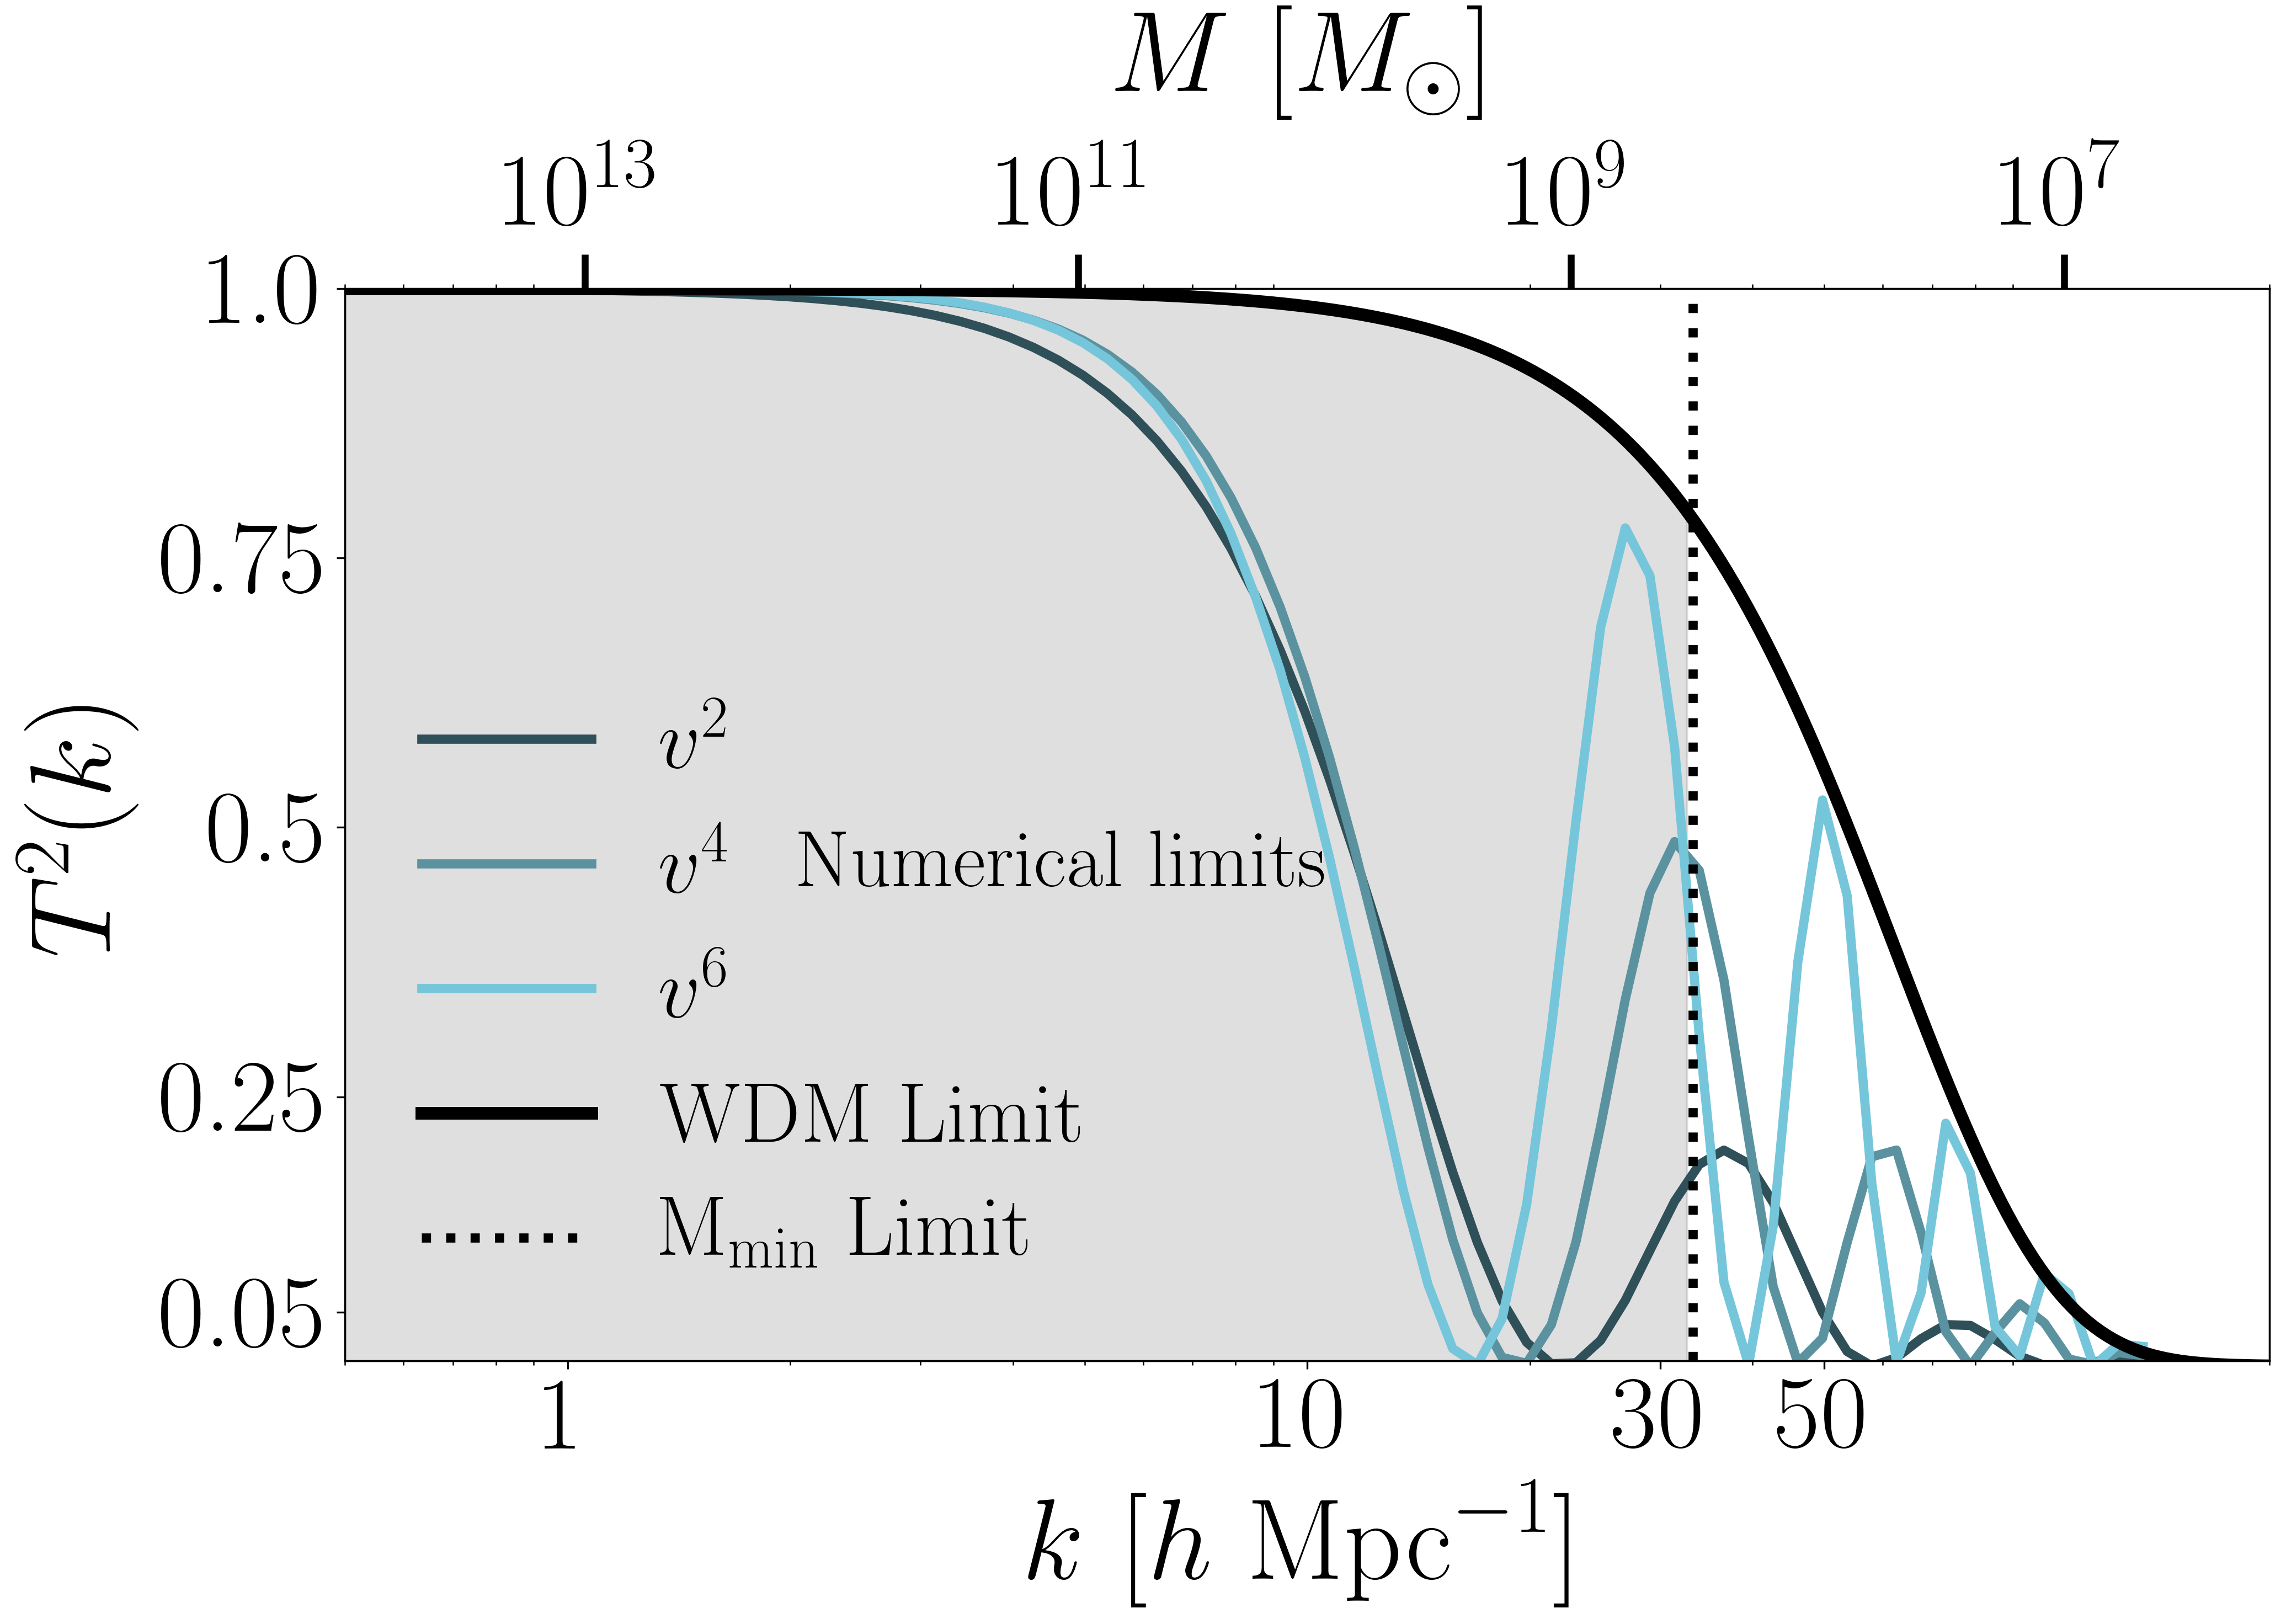

In [13]:
fig = plt.figure(figsize=(14,10))    
ax = fig.add_subplot(111)
ax2 = ax.twiny()

blue1='#2F5058'
blue2='#5B92A0'
blue3='#75C6DA'
red1='#ED578D'
red2='#D81B60'
red3='#7E1038'
ls='-'

######## n=2, m=1 GeV ########
tk_idm_c,ks,sigma0 = vds0.single_tk(npow=2,m=1,ls=ls,c=blue1,label=r'$v^2$',sigmas=n0n2sigs,index=4,lw=4)

######## n=4, m=1 GeV ########
tk_idm_c,ks,sigma0 = vds0.single_tk(npow=4,m=1,ls=ls,c=blue2,label=r'$v^4$',sigmas=n4sigs_m1,index=1,lw=4)

######## n=6, m=1 GeV ########
tk_idm_c,ks,sigma0 = vds0.single_tk(npow=6,m=1,ls=ls,c=blue3,label=r'$v^6$',sigmas=n6sigs_m1,index=17,lw=4)

############################################### WDM/Mmin Limits #########################################################
ks2 = np.logspace(-5,4,1000)
ax.semilogx(ks2,vds0.transfer(ks2,6.5)**2,linestyle='-',label='WDM Limit',c='k',lw=5.5)
ax.axvline(klim,c='k',ls=':',lw=4,label=r'M$_{\rm{min}}$ Limit')
ax.fill_between(np.logspace(-5,4,1000), -10, vds0.transfer(ks2,6.5)**2,where=np.logspace(-5,4,1000)<klim,color='grey',alpha=0.25)

################################################# PLOT OPTIONS #####################################################
ax.set_xscale('log')
ax.set_xlim(0.5,200)
ax.set_ylim(0.005,1.)
ax.set_xlabel(r'$k$ [$h\ \rm{Mpc}^{-1}$]',fontsize=50,labelpad=5)
ax.set_ylabel(r'$T^2(k)$',fontsize=50,labelpad=10)
ax.set_xticks([1,10,30,50])
ax.set_xticklabels(["1","10","30","50"],fontsize=45)
ax.set_yticks([0.05,0.25,0.5,0.75,1.0])
ax.set_yticklabels([0.05,0.25,0.5,0.75,1.0],fontsize=45)
ax.legend(fontsize=37,framealpha=0,loc='lower left')
ax2.text(2.05, 0.445, "Numerical limits",size=35)
ax2.set_xscale('log')
ax2.set_xlim(0.5,200)
ax2.set_xticks([vds0.mhm2khm(10**13),vds0.mhm2khm(10**11),vds0.mhm2khm(10**9),vds0.mhm2khm(10**7)])
ax2.set_xticklabels([r'10$^{13}$',r'10$^{11}$',r'10$^{9}$',r'10$^{7}$'],fontsize=45)
ax2.set_xlabel(r'$M$ [$M_{\rm{\odot}}$]',fontsize=50,labelpad=20)
ax2.tick_params(length=15,width=3)

plt.tight_layout()
plt.savefig("plots/exclusions/tk_numerical.png")



3.795760756249481e-23
data/n2_m1_s3.795760756249481e-23_z1_pk.dat
1.9370696741551177e-18
data/n4_m1_s1.9370696741551177e-18_z1_pk.dat


<ipython-input-7-23638aa32d9a>:62: RuntimeWarning: invalid value encountered in power
  return fsolve(lambda z: z * ((self.T_0*z**2)/((1+self.z_th(sigma_0,m_x,n))*m_x) + (self.T_0*z)/self.m_p)**((n+1.)/2.) - (self.H0*np.sqrt(self.Omega_rad)/(self.N_0(n)*self.Y_p*self.rho_b*self.Rx_conerverionFactor))*(m_x+self.m_p)/sigma_0,self.z_th(sigma_0,m_x,n)/2.)


7.84918757752735e-14
data/n6_m1_s7.84918757752735e-14_z1_pk.dat


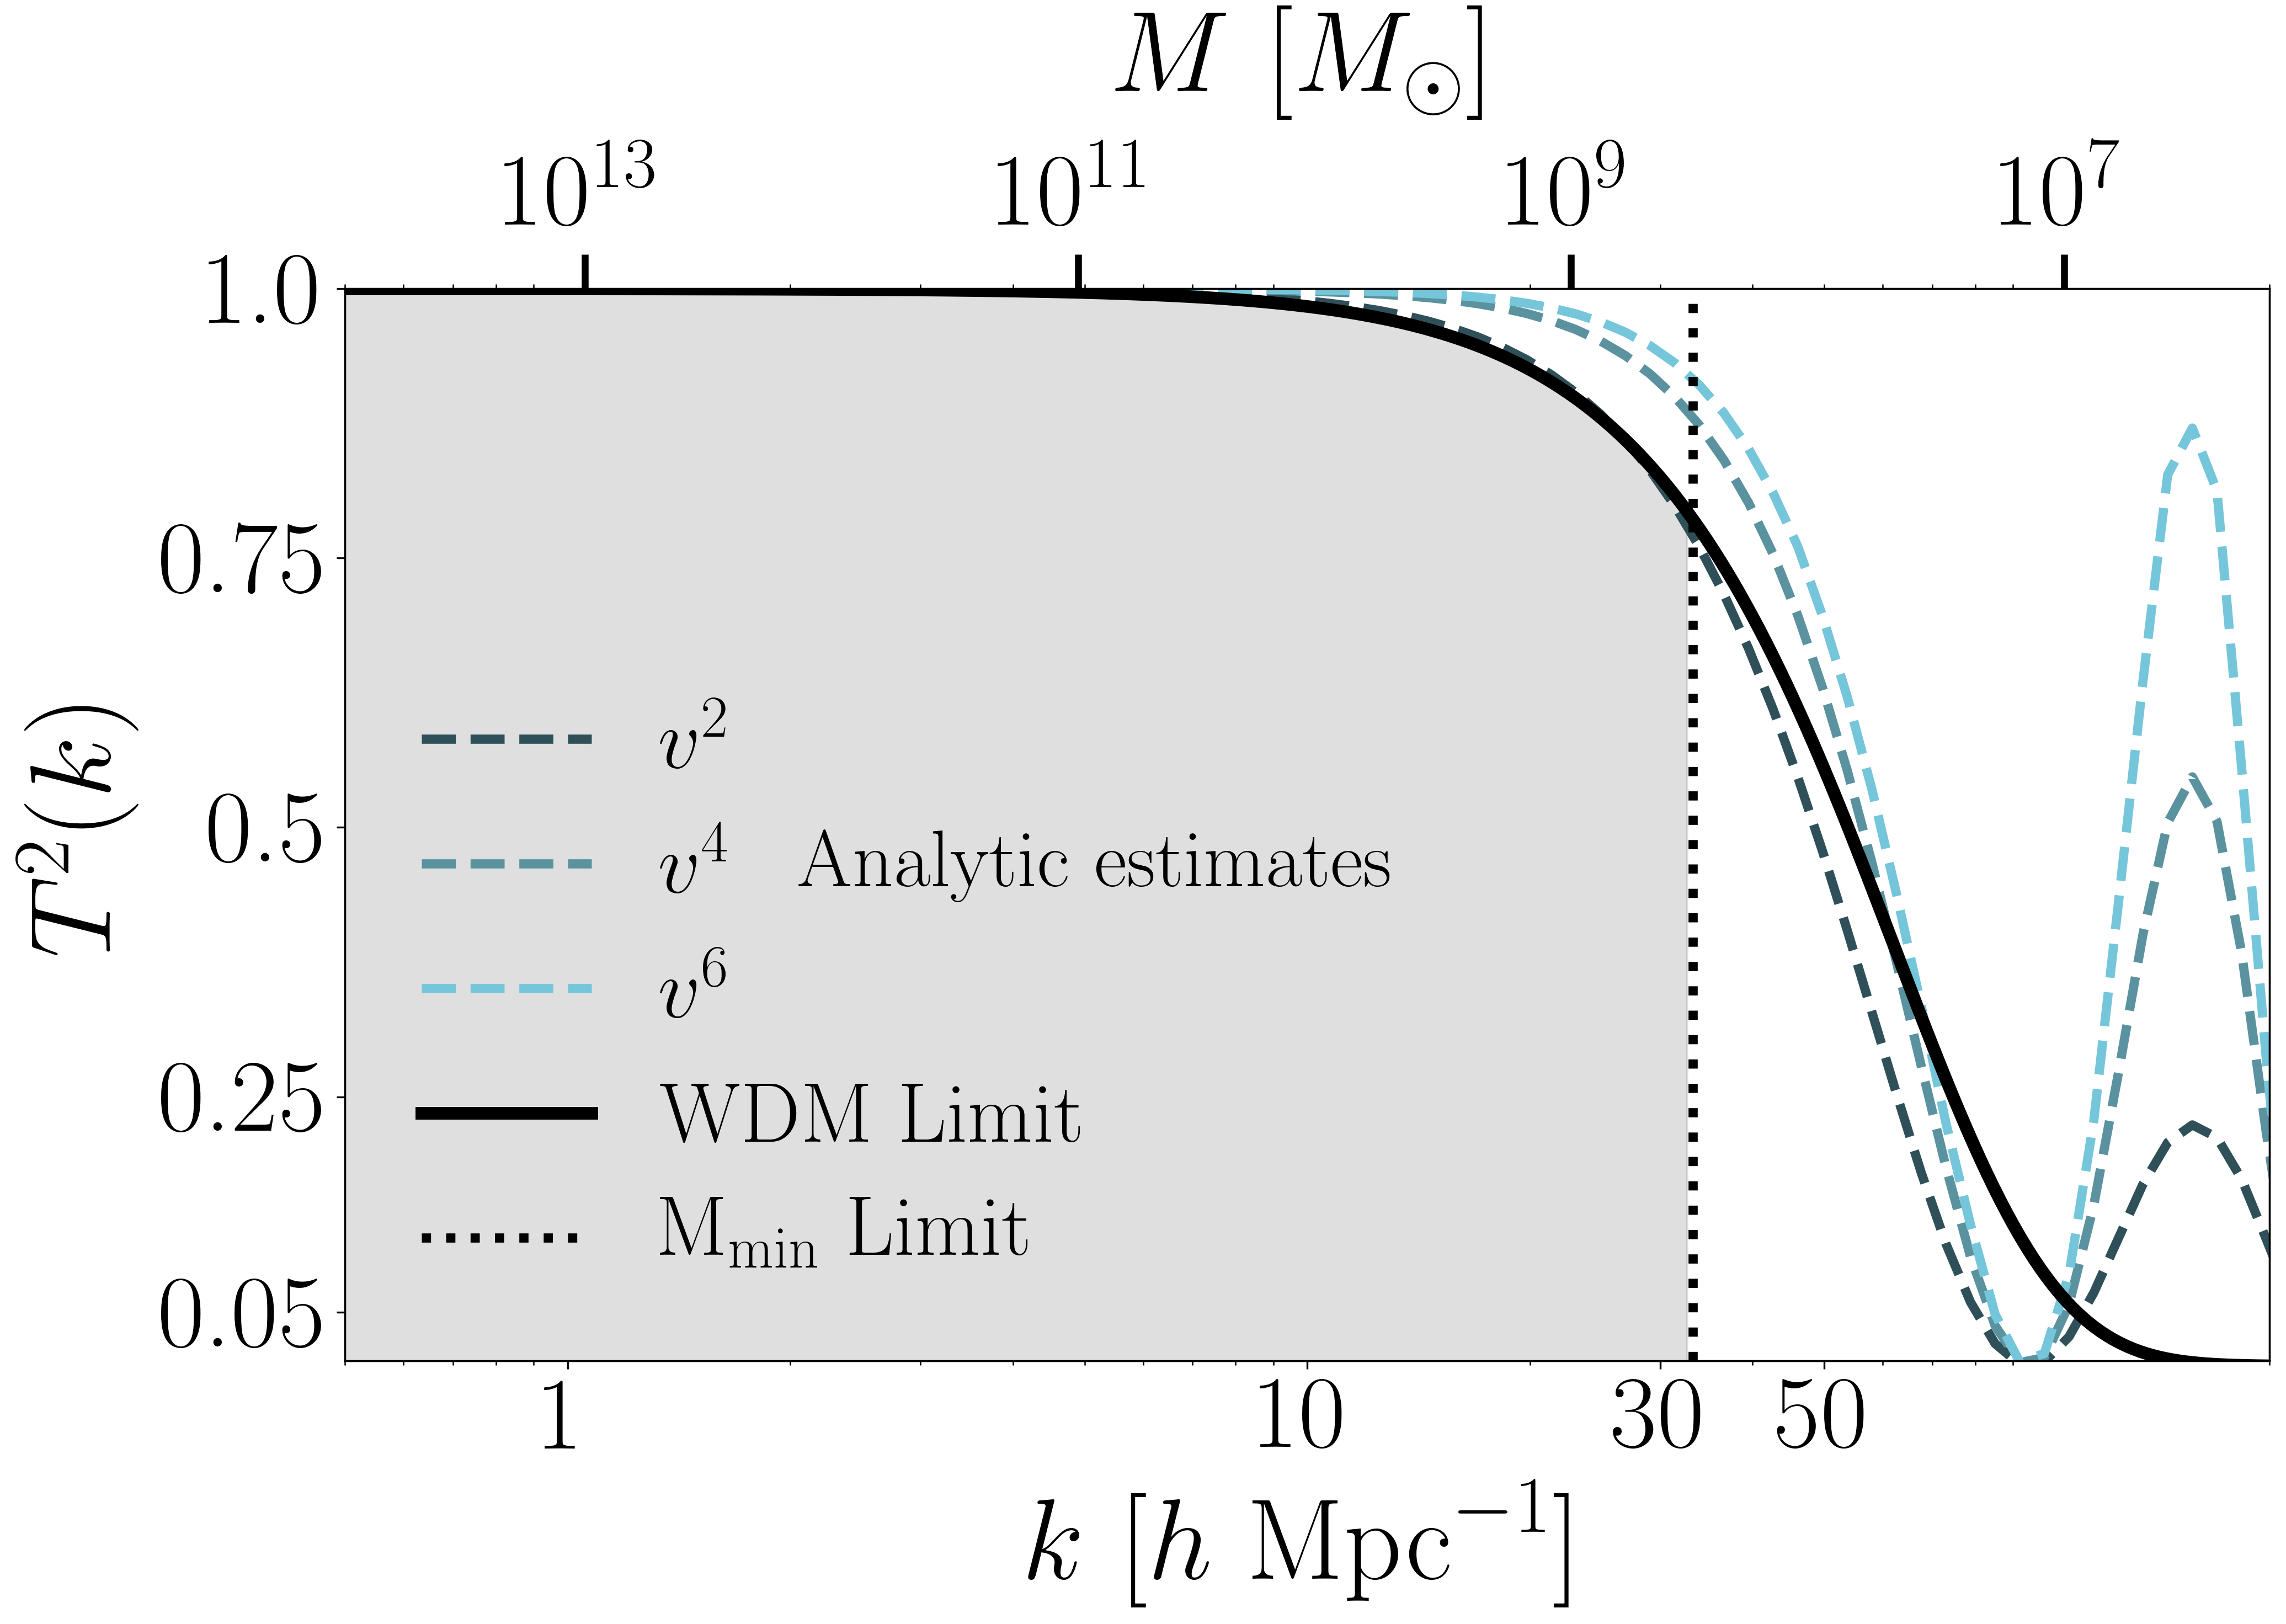

In [16]:
fig = plt.figure(figsize=(14,10))    
ax = fig.add_subplot(111)
ax2 = ax.twiny()

blue1='#2F5058'
blue2='#5B92A0'
blue3='#75C6DA'
red1='#ED578D'
red2='#D81B60'
red3='#7E1038'
ls='--'
######## n=2, m=1 GeV ########
tk_idm_a,ks,sigma0 = vds0.single_tk(approach='analytic',ls=ls,npow=2,m=1,c=blue1,label=r'$v^2$',sigmas=[vds0.sig(klim,2.,vds0.masses)[5]],index=0,lw=4)

######## n=4, m=1 GeV ########
tk_idm_a,ks,sigma0 = vds0.single_tk(approach='analytic',ls=ls,npow=4,m=1,c=blue2,label=r'$v^4$',sigmas=[vds0.sig(klim,4.,vds0.masses)[5]],index=0,lw=4)

######## n=6, m=1 GeV ########
tk_idm_a,ks,sigma0 = vds0.single_tk(approach='analytic',ls=ls,npow=6,m=1,c=blue3,label=r'$v^6$',sigmas=[vds0.sig(klim,6.,vds0.masses)[5]],index=0,lw=4)

############################################### WDM/Mmin Limits #########################################################
ks2 = np.logspace(-5,4,1000)
ax.semilogx(ks2,vds0.transfer(ks2,6.5)**2,linestyle='-',label='WDM Limit',c='k',lw=5.5)
ax.axvline(klim,c='k',ls=':',lw=4,label=r'M$_{\rm{min}}$ Limit')
ax.fill_between(np.logspace(-5,4,1000), -10, vds0.transfer(ks2,6.5)**2,where=np.logspace(-5,4,1000)<klim,color='grey',alpha=0.25)

################################################# PLOT OPTIONS #####################################################
ax.set_xscale('log')
ax.set_xlim(0.5,200)
ax.set_ylim(0.005,1.)
ax.set_xlabel(r'$k$ [$h\ \rm{Mpc}^{-1}$]',fontsize=50,labelpad=5)
ax.set_ylabel(r'$T^2(k)$',fontsize=50,labelpad=10)
ax.set_xticks([1,10,30,50])
ax.set_xticklabels(["1","10","30","50"],fontsize=45)
ax.set_yticks([0.05,0.25,0.5,0.75,1.0])
ax.set_yticklabels([0.05,0.25,0.5,0.75,1.0],fontsize=45)
ax.legend(fontsize=37,framealpha=0,loc='lower left')
ax2.text(2.05, 0.445, "Analytic estimates",size=35)
ax2.set_xscale('log')
ax2.set_xlim(0.5,200)
ax2.set_xticks([vds0.mhm2khm(10**13),vds0.mhm2khm(10**11),vds0.mhm2khm(10**9),vds0.mhm2khm(10**7)])
ax2.set_xticklabels([r'10$^{13}$',r'10$^{11}$',r'10$^{9}$',r'10$^{7}$'],fontsize=45)
ax2.set_xlabel(r'$M$ [$M_{\rm{\odot}}$]',fontsize=50,labelpad=20)
ax2.tick_params(length=15,width=3)

plt.tight_layout()
plt.savefig("plots/exclusions/tk_analitic.png")


